# Exploratory Data Analysis <a name = 'content'></a>    

The task of this notebook is to prepare data for model training. At the end we will get cleaned data consisting of only useful features.

### Steps   

* [Import](#import)
* [Data Loading and First Familiarization](#loading)  
* [Missing Data Excludinging](#missing_data)    
* [First Look at the Correlation](#correlation)    
* [Mutual Information Scores](#MI)    
* [Features Selection](#selection)   
* [Outliers Excluding](#outliers)    
* [Categorical Variables Encoding](#encoding)    
* [Saving the Processed Data](#csv)   
* [Fitting Data to Statistical Norms](#stats)   
* [Saving Data with Normalized Columns](#save_norm)   

# Import <a name = 'import'></a>

[Table of Contents](#content)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from scipy.stats import norm

# Data Loading and First Familiarization <a name = 'loading'></a>    

[Table of Contents](#content)  

In [75]:
# Load the training and the validation data
train_file_path = '../../Data/train_origin.csv'
test_file_path = '../../Data/test_origin.csv'

train_data = pd.read_csv(train_file_path, index_col = 'Id')
test_data = pd.read_csv(test_file_path, index_col = 'Id')

The data was taken from Kaggle competition, that's why test set doesn't have a `SalePrice` (target feature).

In [76]:
# Removing the restrictions to see all the features
pd.set_option('display.max_columns', None)

print(train_data.shape)
train_data.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


There are many features, both numeric and categorical, and obviously not all of them are useful. Also conspicuous is the large number of missing values.     

Let's look at the target value in a little more detail.

In [77]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We don't have zero values here, and that's a good thing.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

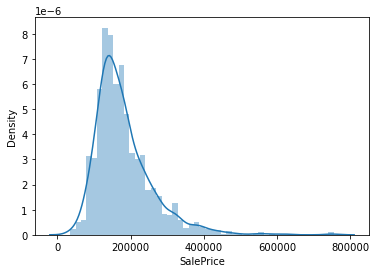

In [78]:
sns.distplot(train_data['SalePrice'])

The target variable deviates from the normal distribution and it may be a good idea to normalize it in the future.

Okay, it's time to separate target variable from other features.

In [79]:
X = train_data.copy()
y = X['SalePrice']
X = X.drop(['SalePrice'], axis = 1)

We can't do much if our data has missing values, so...

# Missing Data Excluding <a name = 'missing_data'></a>

[Table of Contents](#content)


I want to minimize the impact of missing values on my model, but at the same time there are only 1460 rows in the training dataset, which is not that many. I don't want to distort the data with a large number of imputed values, and I can't afford to just drop every row with missing data. The only way out is to exclude missing data in some softer and more individualized way. Weigh the pros and cons of keeping or excluding a column or row...   

Train data first.

In [80]:
# Get the number of missing values for each column
for col in X.columns:
    print(col, '- ', X[col].isnull().sum())

X.shape

MSSubClass -  0
MSZoning -  0
LotFrontage -  259
LotArea -  0
Street -  0
Alley -  1369
LotShape -  0
LandContour -  0
Utilities -  0
LotConfig -  0
LandSlope -  0
Neighborhood -  0
Condition1 -  0
Condition2 -  0
BldgType -  0
HouseStyle -  0
OverallQual -  0
OverallCond -  0
YearBuilt -  0
YearRemodAdd -  0
RoofStyle -  0
RoofMatl -  0
Exterior1st -  0
Exterior2nd -  0
MasVnrType -  8
MasVnrArea -  8
ExterQual -  0
ExterCond -  0
Foundation -  0
BsmtQual -  37
BsmtCond -  37
BsmtExposure -  38
BsmtFinType1 -  37
BsmtFinSF1 -  0
BsmtFinType2 -  38
BsmtFinSF2 -  0
BsmtUnfSF -  0
TotalBsmtSF -  0
Heating -  0
HeatingQC -  0
CentralAir -  0
Electrical -  1
1stFlrSF -  0
2ndFlrSF -  0
LowQualFinSF -  0
GrLivArea -  0
BsmtFullBath -  0
BsmtHalfBath -  0
FullBath -  0
HalfBath -  0
BedroomAbvGr -  0
KitchenAbvGr -  0
KitchenQual -  0
TotRmsAbvGrd -  0
Functional -  0
Fireplaces -  0
FireplaceQu -  690
GarageType -  81
GarageYrBlt -  81
GarageFinish -  81
GarageCars -  0
GarageArea -  0
Gara

(1460, 79)

I will start the cleanup with features that have too many missing values, making them unusable. None of these features are worth losing 17+% of my data.

In [81]:
X = X.drop(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1)

There are features that contain information that only appear after the house is sold. I will drop them to prevent data leakage.

In [82]:
X = X.drop(['MoSold', 'YrSold', 'SaleType', 'SaleCondition'], axis = 1)

There are some columns that contain some missing values (<1%). In this case I will drop only rows to keep the other information in the columns.

In [83]:
X = X.dropna(subset = ['MasVnrType', 'MasVnrArea', 'Electrical'])

There are many basement-describing features with ~37 missing rows in there. I believe these are the same rows, so I'll drop only them. 

In [84]:
X = X.dropna(subset = ['BsmtCond', 'BsmtFinType1', 'BsmtQual', 'BsmtFinType2', 'BsmtExposure'])

There are also garage-describing features with 81 rows missing. This is more than 5% of data. Do I want to lose 5% of data because of garage-describing features? I don't think so. Especially when I have a `GarageCars` and `GarageArea` features with no missing values, which seems to be a good estimate of the main property of a garage - size. So, I will drop garage-describing columns with missing values. 

In [85]:
X = X.drop(['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt'], axis = 1)

In [86]:
# Check that no missing values left
X.isnull().sum().max()

0

Tallying up the losses.

In [87]:
X.shape

(1412, 64)

We've lost about `3.2%` of data. I can't say that this is great news, but we definitely can live with that.

In [88]:
# Ensure that X and y have information about the same houses
y = y[X.index]

### Now let's check the missing values in the test data.

In [89]:
print(test_data.shape)
test_data.head(3)

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


As mentioned above, the data was taken from Kaggle, which means that there is no way to evaluate the prediction accuracy of the model other than to make a submission to the competition. For this reason, I cannot drop any rows, as the submission must contain a certain number of observations. Thus, the way to handle missing data in the validation set is different from the way to handle the training set. Now I will use only imputation, I hope it is clear why.

In [90]:
# Drop useless columns from test data
test_data = test_data[X.columns]

# Print the number of missing values
for column in test_data.columns:
    print(column, ' ', test_data[column].dtype, ': ', test_data[column].isnull().sum())

MSSubClass   int64 :  0
MSZoning   object :  4
LotArea   int64 :  0
Street   object :  0
LotShape   object :  0
LandContour   object :  0
Utilities   object :  2
LotConfig   object :  0
LandSlope   object :  0
Neighborhood   object :  0
Condition1   object :  0
Condition2   object :  0
BldgType   object :  0
HouseStyle   object :  0
OverallQual   int64 :  0
OverallCond   int64 :  0
YearBuilt   int64 :  0
YearRemodAdd   int64 :  0
RoofStyle   object :  0
RoofMatl   object :  0
Exterior1st   object :  1
Exterior2nd   object :  1
MasVnrType   object :  16
MasVnrArea   float64 :  15
ExterQual   object :  0
ExterCond   object :  0
Foundation   object :  0
BsmtQual   object :  44
BsmtCond   object :  45
BsmtExposure   object :  44
BsmtFinType1   object :  42
BsmtFinSF1   float64 :  1
BsmtFinType2   object :  42
BsmtFinSF2   float64 :  1
BsmtUnfSF   float64 :  1
TotalBsmtSF   float64 :  1
Heating   object :  0
HeatingQC   object :  0
CentralAir   object :  0
Electrical   object :  0
1stFlrSF 

I will fill in the missing values in the numeric columns using median values because I know there are outliers in the data. And the missing values in the categorical columns will be filled in using mode values.

In [91]:
# Get numerical and categorical features with missing values into separate variables
num_cols_with_missing = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

cat_cols_with_missing = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond',
                        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual',
                        'Functional', 'GarageCars']

# Create imputer objects
num_imputer = SimpleImputer(strategy = 'median')
cat_imputer = SimpleImputer(strategy = 'most_frequent')

# Fill in the missing data
test_data[num_cols_with_missing] = num_imputer.fit_transform(test_data[num_cols_with_missing])
test_data[cat_cols_with_missing] = cat_imputer.fit_transform(test_data[cat_cols_with_missing])

In [92]:
# Check that no missing values left
test_data.isnull().sum().max()

0

# First Look at the Correlation <a name = 'correlation'></a>

[Table of Contents](#content)

The next task is to determine which features are **objectively** useful and which are useless.   

I will do this in two steps. First, I will drop the features that are clearly useless. Heatmap and Box-plots will help me with this. (Actually, Heatmap is also a good tool for identifying multilinear features.) And then I'll get mutual information scores to decide what to do with the rest of the features.

In [93]:
# At first we need to divide features into numerical and categorical
print(list(X.dtypes.unique()))

[dtype('int64'), dtype('O'), dtype('float64')]


In [94]:
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

cat_cols = [col for col in X.columns if X[col].dtype in ['O']]

### Heatmap

<AxesSubplot:title={'center':'Relationships between num_cols and the target'}>

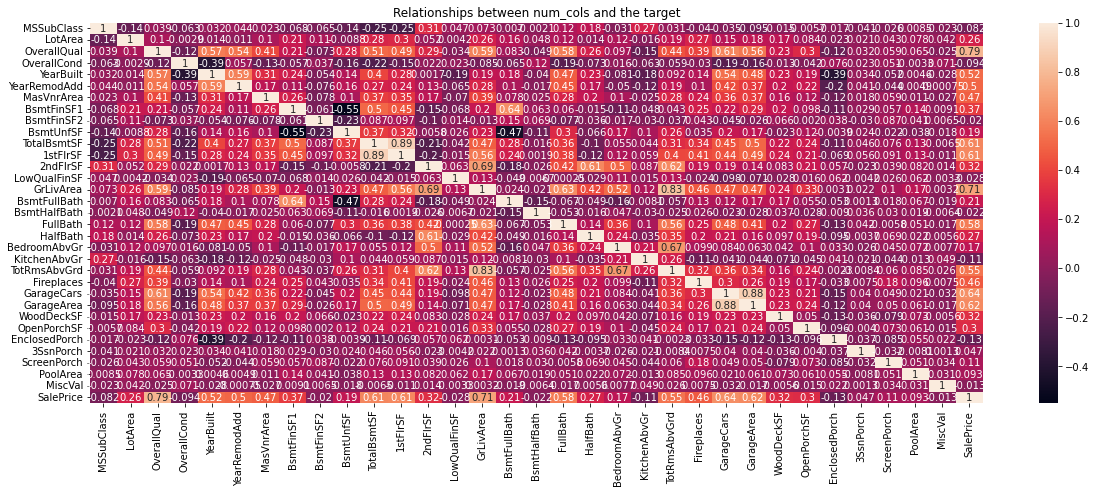

In [95]:
heatmap_data = pd.concat([X[num_cols], y], axis = 1)

plt.figure(figsize=(20,7))
plt.title('Relationships between num_cols and the target')
sns.heatmap(data=heatmap_data.corr(), annot = True)

I will drop features that have less than 20% correlation with SalePrice.

In [96]:
X = X.drop(['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 
            'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], axis=1)

There is some doubt about features with 20 - 40% correlation with `SalePrice`. Perhaps these features correlate with the target in a non-linear way, so heatmap can't recognize this. Or maybe these features just aren't that good at predicting price. In any case, I will determine the future of these features after calculating the mutual information.    

### Multi colinearity   

Usually, all features that have a correlation coefficient above 0.8 are considered multicolinear. If we look at the heatmap, we see that we have three pairs of such features:     
* 1stFlrSF - TotalBsmtSF    
* GarageArea - GarageCars    
* GrLivArea - TotRmsAbvGrd   

Multicolinearity doesn't do our model any good, so one feature from each pair is worth removing. I will remove those features that will receive a lower mutual information score.    




### OverallQual

Another thing that I think is worth mentioning is the very strong correlation between the target variable and `OverallQual`. OverallQual is like a super feature (correlation coefficient 0.79). 

On the one hand one can assume that there is nothing wrong with this feature and I am lucky to have such good fortune in my project. After all, there are other pairs of variables with high correlation coefficients that are not suspicious. For example, `2ndFlrSF` (Second floor square feet) - `GrLivArea` (Above grade (ground) living area square feet) with correlation coefficient 0.69.

On the other hand, if we take a closer look at OverallQual, several problems become apparent. If we look in the description of this feature, we see that it's "Rates the overall material and finish of the house". Doesn't seem like a value that can be measured precisely. Let's look further. OverallQual takes values from 1 to 10, where 1 means "Very Poor" and 10 means "Very Excellent". In other words, it's more like a subjective value (unlike 2ndFlrSF, GrLivArea, which change in square feet). Also, we don't know anything about when the OverallQual value appears. Perhaps it's the estimate a customer puts on it after buying a house, and then including that feature in the model would be a great example of Data Leakage.   

However, if we do not look at OverallQual in isolation, but look at the data as a whole, we can see that the data is replete with features describing the quality (ExterQual, BsmtQual, GarageQual etc.) and finality (LowQualFinSF, BsmtFinSF2, GarageFinish etc.) of individual parts of a house. And while I have little faith that real estate agents have an accurate "ruler" for measuring overall quality and finality of a whole house from 1 to 10, I have a lot of faith that there is such a clear scoring system for each individual element of a house. In such a case, it is logical to assume that OverallQual is not a subjective abstraction taken out of thin air, but simply a summary that is derived from a multitude of quite objective assessments.

**My conclusion**: OverallQual is not a trap-feature that leads to data leakage and overfitting, but a feature engineering that is done for us.

### Boxplots

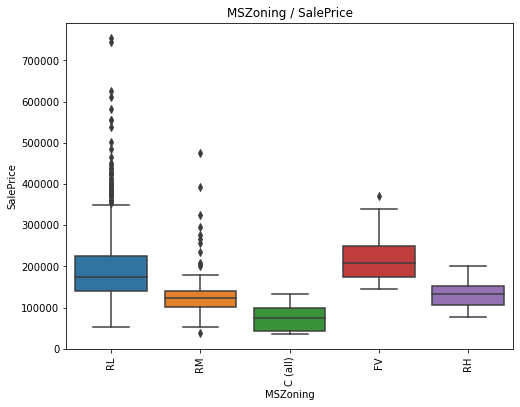

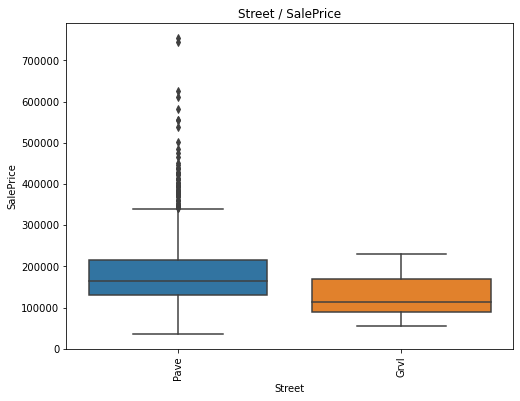

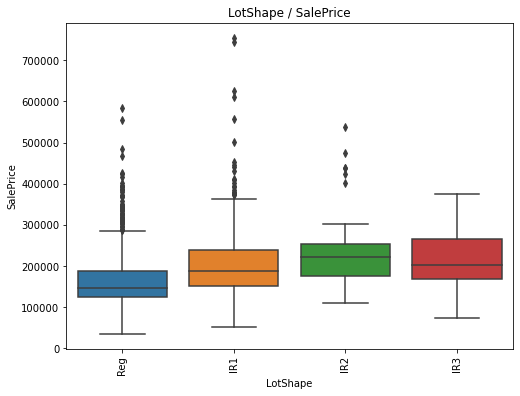

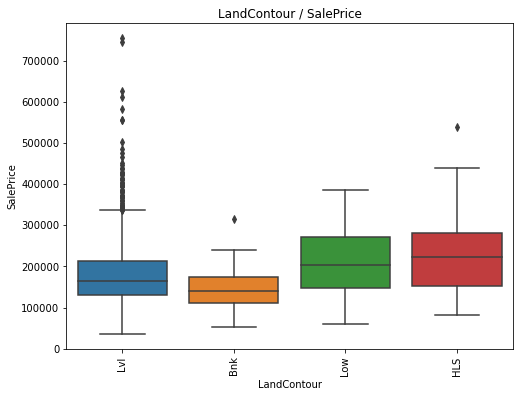

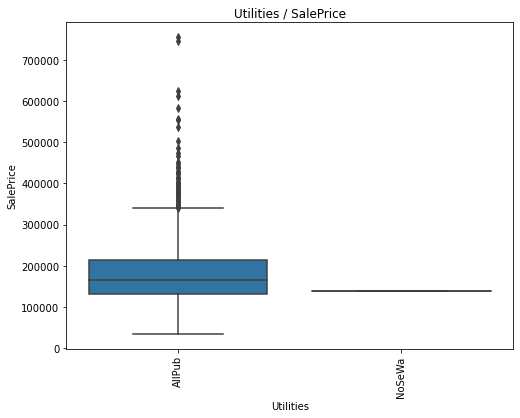

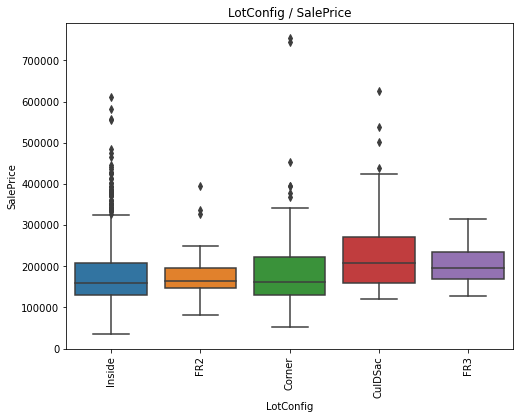

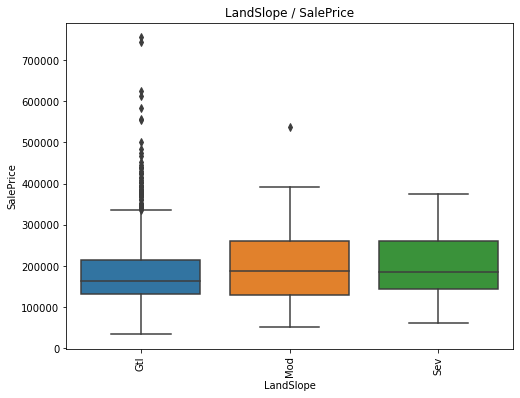

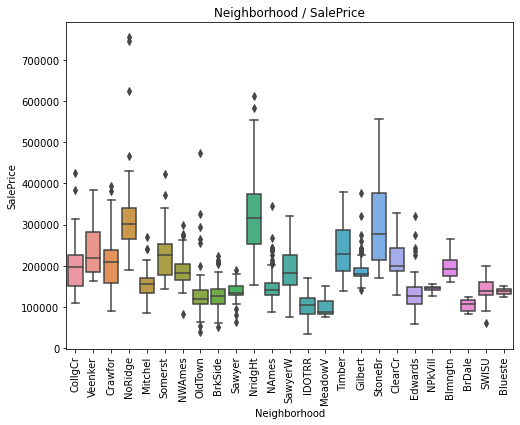

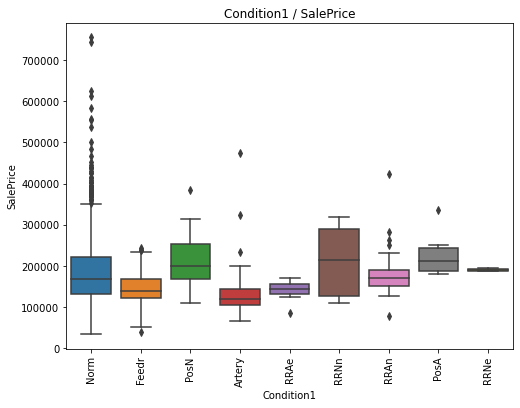

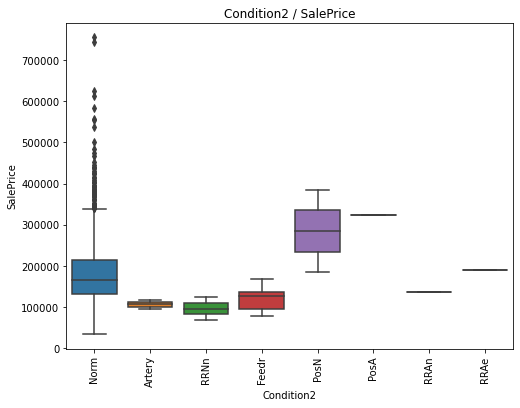

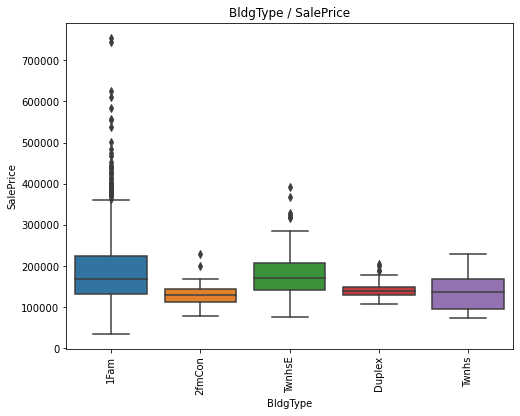

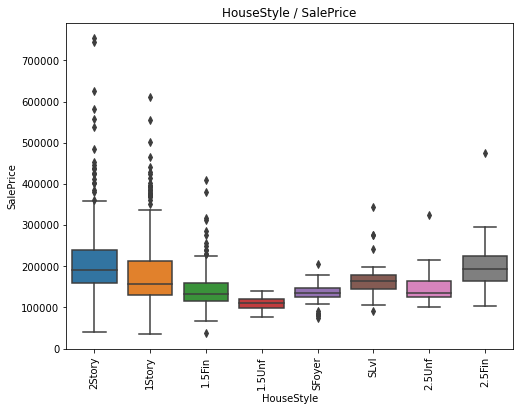

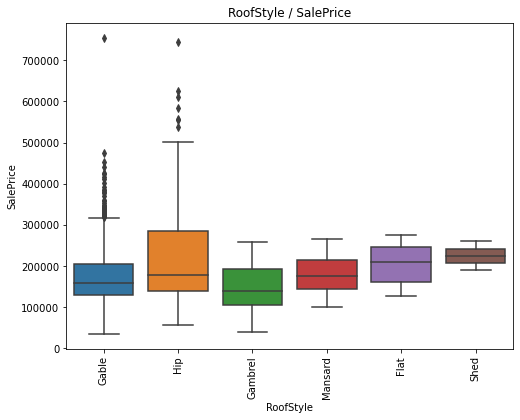

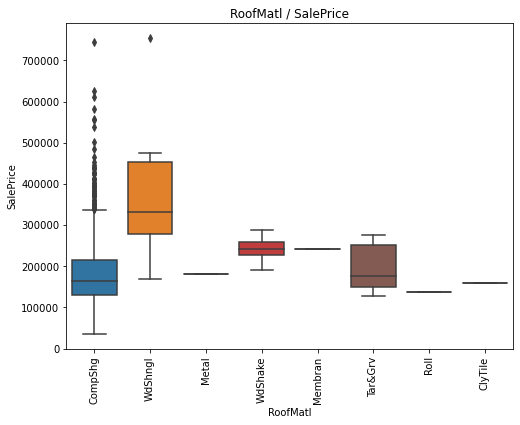

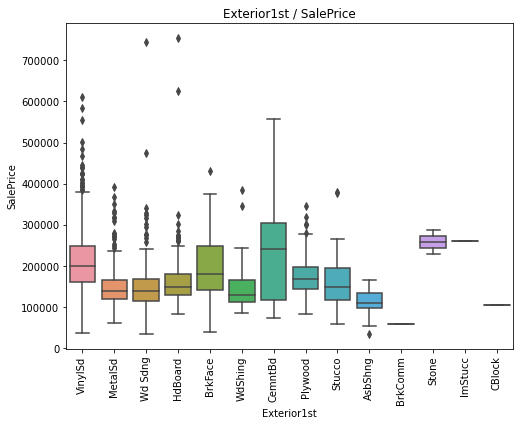

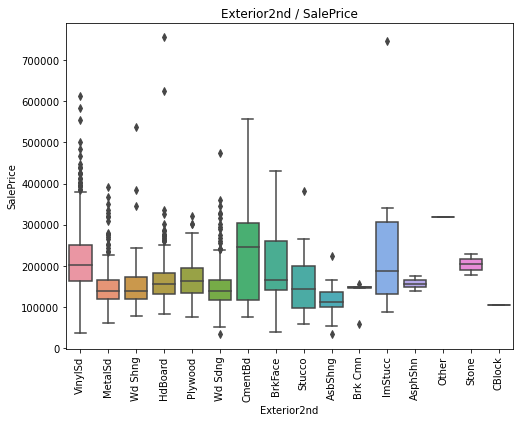

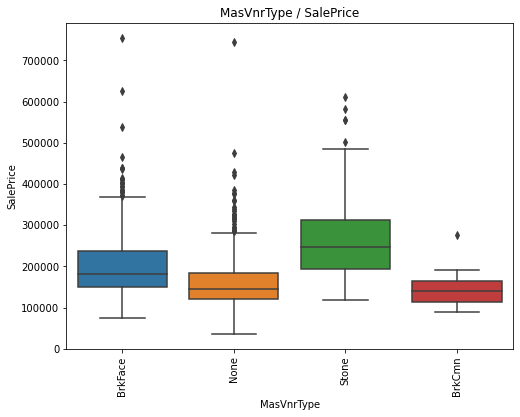

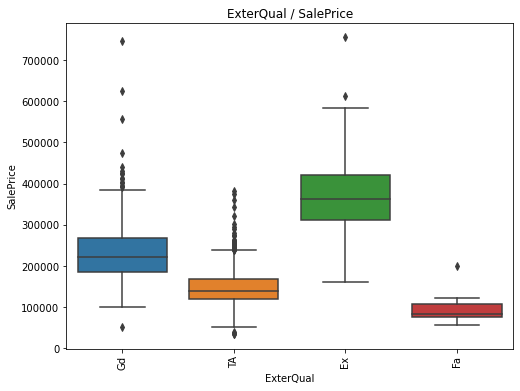

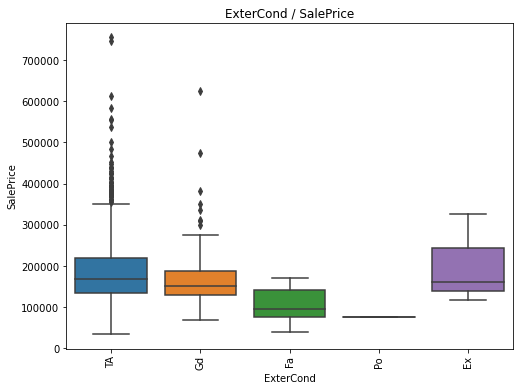

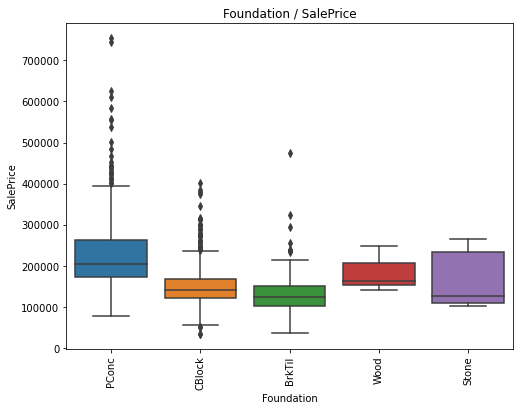

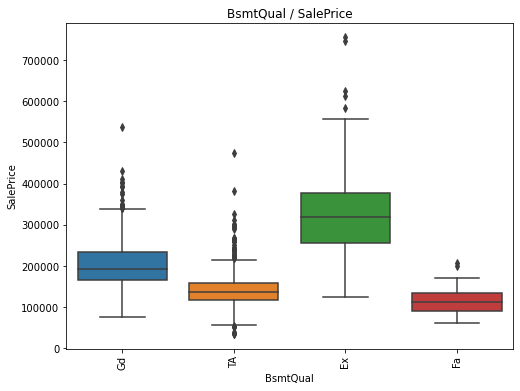

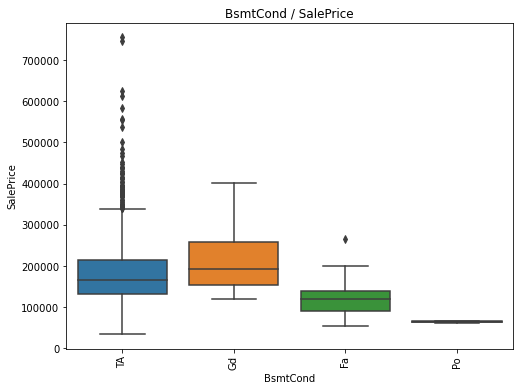

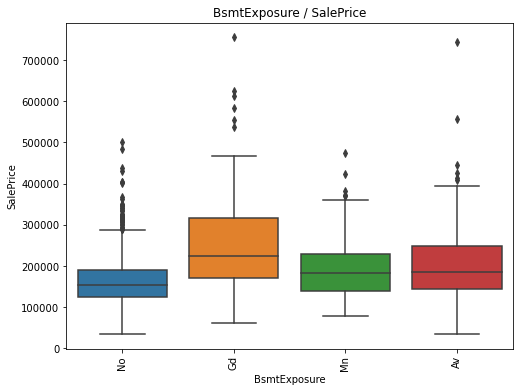

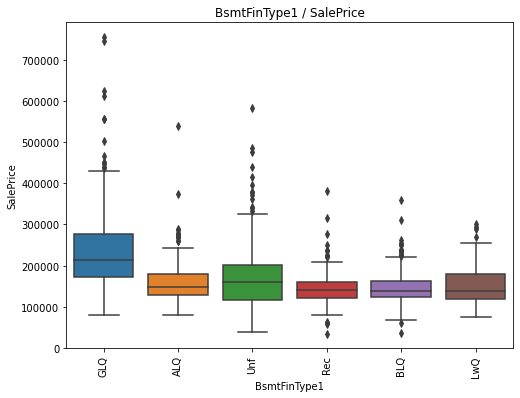

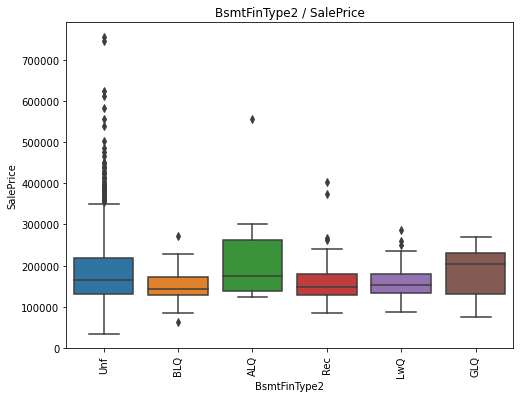

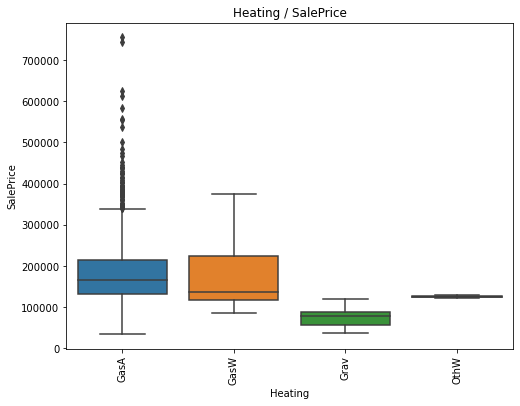

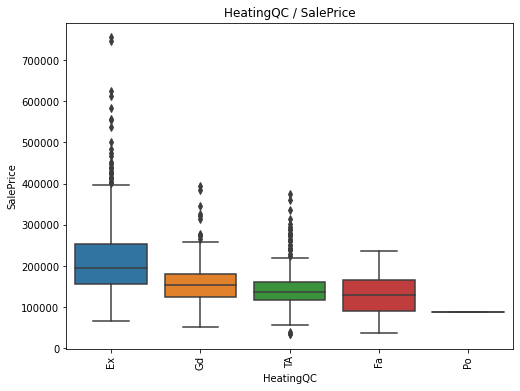

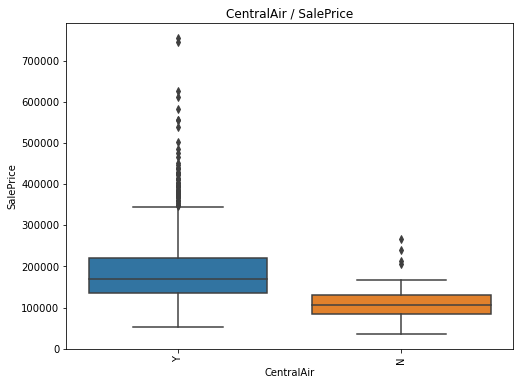

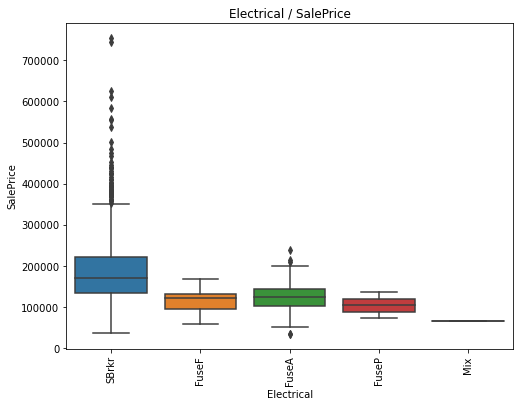

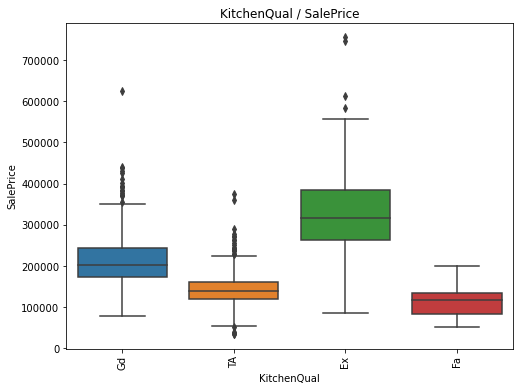

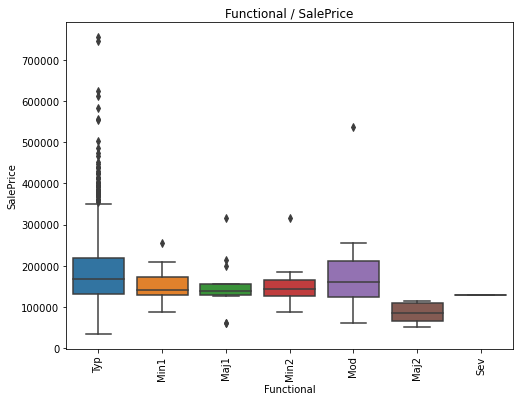

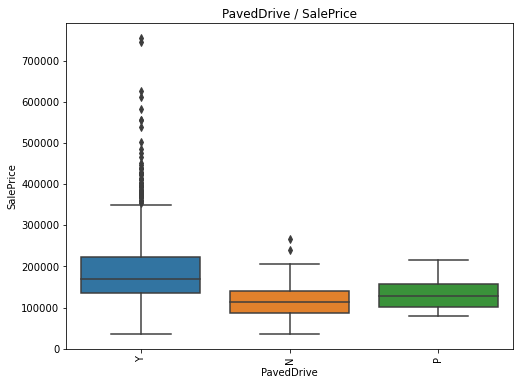

In [97]:
# Let's create a boxplots to see the link between categorical features and target

for feature in cat_cols:
    boxplot_data = pd.concat([X[feature], y], axis = 1)
    plt.figure(figsize=(8, 6))
    plt.title(f'{feature} / SalePrice')
    sns.boxplot(x = feature, y="SalePrice", data=boxplot_data)
    plt.xticks(rotation=90)


Some features show no correlation with `SalePrice` or the correlation is too small, so I will drop these features immediately.

In [98]:
X = X.drop(['LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'RoofStyle', 
            'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'Functional'], axis = 1)

I'm not sure about many features, where is definitely a correlation, but is there enough correlation to call these features useful in terms of model training? There is no way to say for sure. Let me postpone the decision until the mutual information is computed.    

# Mutual Information Scores <a name = 'MI'></a>

[Table of Contents](#content)

I use mutual information (MI) to double-check all my previous work. MI will help me decide what to do about features that I have doubts about. So, let's dive in!

### Categorical Encoding  

MI will be implemented using `mutual_info_regression` which can only handle numeric features. So I need to convert categorical features first. 

In [99]:
# For now I don't want to change the original data. That's why create a copy
X_MI = X.copy()

# Exclude from cat_cols columns that were dropped on previous steps
cat_cols = [col for col in X.columns if X[col].dtype in ['O']] 

# mutual_info_regression is not hierarchy-sensitive, and I don't want to increase data processing 
# time by using a one-hot, so... LabelEncoder
label_encoder = LabelEncoder()

for col in X_MI[cat_cols]:
    X_MI[col] = label_encoder.fit_transform(X_MI[col])
    
X_MI.head(1)

,MSZoning,LotArea,Street,LotShape,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,TotalBsmtSF,Heating,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,8450,1,3,5,2,2,0,5,7,2003,2003,1,11,13,1,196.0,2,4,2,2,3,3,706,856,0,1,856,854,1710,1,2,1,2,8,0,2,548,2,0,61


Now there are only numerical data. That's good)

### Discrete and Continuing features 

`mutual_info_regression` is sensitive to the discrete / continuous feature property. So we need to explicitly define where in our data is a variable of what type.

In [100]:
X.select_dtypes(['int64', 'float64']).columns

Index(['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

In [101]:
# Create separate variables for discrete and continuing features
continuing_features = ['LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', '1stFlrSF', 
                       '2ndFlrSF', 'BsmtFinSF1', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']

discrete_features = set(X_MI.columns) - set(continuing_features)
discrete_features = list(discrete_features)

Convert the data types to `int` for discrete features and `float` for continuing features. This is also a requirement of `mutual_info_regression`.

In [102]:
X_MI[continuing_features] = X_MI[continuing_features].astype('float')
X_MI[discrete_features] = X_MI[discrete_features].astype('int')

# create a boolean mask which we will give to mutual_info_regression
discrete_bool_list = X.dtypes == int

### Mutual Information scores computing

In [103]:
# compute MI
mi_scores = mutual_info_regression(X_MI, y, discrete_features= discrete_bool_list)

# transform it to the beautifull Series) 
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

# descent order
mi_scores = mi_scores.sort_values(ascending=False)

In [104]:
for feature in mi_scores.index:
    print(feature, ' ', "{:.3f}".format(mi_scores[feature]))

OverallQual   0.547
Neighborhood   0.513
GrLivArea   0.487
YearBuilt   0.371
GarageArea   0.371
GarageCars   0.359
TotalBsmtSF   0.349
BsmtQual   0.333
1stFlrSF   0.326
KitchenQual   0.319
ExterQual   0.314
FullBath   0.280
YearRemodAdd   0.262
TotRmsAbvGrd   0.222
2ndFlrSF   0.199
Foundation   0.181
Exterior2nd   0.170
LotArea   0.163
Fireplaces   0.157
OpenPorchSF   0.150
Exterior1st   0.148
BsmtFinSF1   0.144
MSZoning   0.138
WoodDeckSF   0.109
MasVnrType   0.090
MasVnrArea   0.086
HouseStyle   0.086
HalfBath   0.077
LotShape   0.077
PavedDrive   0.056
BsmtExposure   0.053
CentralAir   0.053
Condition1   0.029
BsmtFullBath   0.027
Condition2   0.026
BldgType   0.024
BsmtCond   0.021
ExterCond   0.011
Heating   0.002
Street   0.000
RoofMatl   0.000


# Features Selection <a name = 'selection'></a>

[Table of Contents](#content)   

It's time to decide which features to use to train the model. Now we have all the information we need. Let's get started!

I will immediately exclude all features with a score less than `0.13`, as they do not promise to be useful. (Honestly, this threshold is completely subjective, but in future notebooks I will try different numbers of features)

In [105]:
selected_features = list(mi_scores[mi_scores > 0.13].index)
selected_features

['OverallQual',
 'Neighborhood',
 'GrLivArea',
 'YearBuilt',
 'GarageArea',
 'GarageCars',
 'TotalBsmtSF',
 'BsmtQual',
 '1stFlrSF',
 'KitchenQual',
 'ExterQual',
 'FullBath',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 '2ndFlrSF',
 'Foundation',
 'Exterior2nd',
 'LotArea',
 'Fireplaces',
 'OpenPorchSF',
 'Exterior1st',
 'BsmtFinSF1',
 'MSZoning']

Then I will drop the multicolinear features with lower score.

In [106]:
features_for_model_training = [feature for feature in selected_features if 
                               feature not in ['1stFlrSF', 'GarageCars', 'TotRmsAbvGrd']]

Since we have a good generalized `OverallQual` feature, we don't need other features describing quality and finality.

In [107]:
features_for_model_training = [feature for feature in features_for_model_training if 
                               feature not in ['KitchenQual', 'ExterQual', 'BsmtQual', 'BsmtFinSF1']]


I also don't like `MSZoning` because I already have good feature `Neighborhood` which describes location of a house.

In [108]:
features_for_model_training = [feature for feature in features_for_model_training if 
                               feature not in ['MSZoning']]

In [109]:
features_for_model_training

['OverallQual',
 'Neighborhood',
 'GrLivArea',
 'YearBuilt',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'YearRemodAdd',
 '2ndFlrSF',
 'Foundation',
 'Exterior2nd',
 'LotArea',
 'Fireplaces',
 'OpenPorchSF',
 'Exterior1st']

I ended up with 15 features instead of 80, that I think are the most useful for predicting the price of a house. That's great!

In [110]:
X = X[features_for_model_training]

X.head(1)

,OverallQual,Neighborhood,GrLivArea,YearBuilt,GarageArea,TotalBsmtSF,FullBath,YearRemodAdd,2ndFlrSF,Foundation,Exterior2nd,LotArea,Fireplaces,OpenPorchSF,Exterior1st
Id,,,,,,,,,,,,,,,
1,7,CollgCr,1710,2003,548,856,2,2003,854,PConc,VinylSd,8450,0,61,VinylSd


# Outliers<a name = 'outliers'></a>   

[Table of Contents](#content)

One of the best ways to find outliers is to visualize the data. To do this, I'm going to use scatter plots and box plots. 

In [111]:
X.dtypes

OverallQual      int64
Neighborhood    object
GrLivArea        int64
YearBuilt        int64
GarageArea       int64
TotalBsmtSF      int64
FullBath         int64
YearRemodAdd     int64
2ndFlrSF         int64
Foundation      object
Exterior2nd     object
LotArea          int64
Fireplaces       int64
OpenPorchSF      int64
Exterior1st     object
dtype: object

### Outliers in numerical columns

#### GrLivArea

Text(0.5, 0.98, 'Scatterplot of GrLivArea vs. SalePrice')

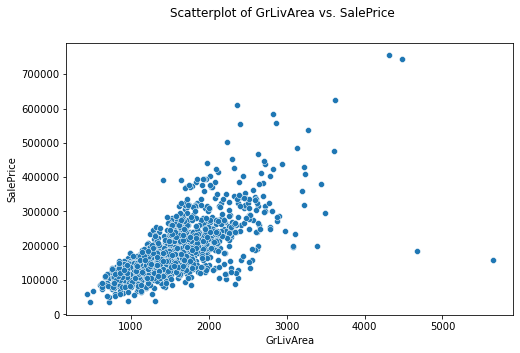

In [112]:
plt.figure(figsize = (8, 5))
sns.scatterplot(x=X['GrLivArea'], y=y)

plt.suptitle('Scatterplot of GrLivArea vs. SalePrice')

Here are the two outliers in the lower right corner of the graph, and I'll drop those values. The rest of the data seems to follow the same distribution pattern.

In [113]:
indices_to_remove = X['GrLivArea'].nlargest(2).index

X = X.drop(indices_to_remove)

#### GarageArea

Text(0.5, 0.98, 'Scatterplot of GarageArea vs. SalePrice')

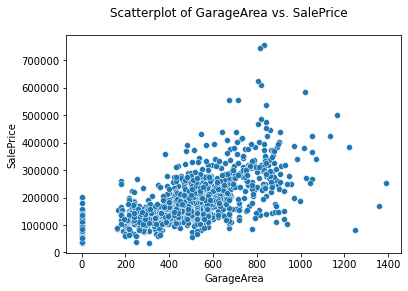

In [114]:
sns.scatterplot(x=X['GarageArea'], y=y)

plt.suptitle('Scatterplot of GarageArea vs. SalePrice')

This distribution is cone-shaped. The three houses with the biggest basements look like outliers.

In [115]:
indices_to_remove = X['GarageArea'].nlargest(3).index

X = X.drop(indices_to_remove)

#### TotalBsmtSF

Text(0.5, 0.98, 'Scatterplot of TotalBsmtSF vs. SalePrice')

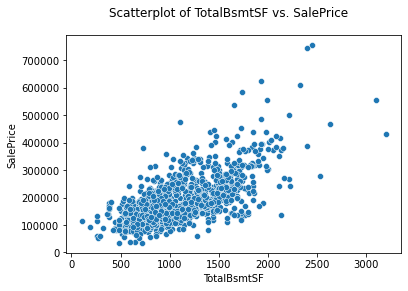

In [116]:
sns.scatterplot(x=X['TotalBsmtSF'], y=y)

plt.suptitle('Scatterplot of TotalBsmtSF vs. SalePrice')

All the data here also seems to follow the same pattern.

#### 2ndFlrSF

Text(0.5, 0.98, 'Scatterplot of 2ndFlrSF vs. SalePrice')

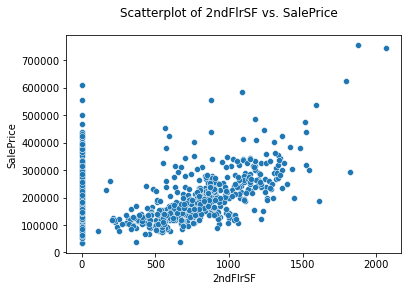

In [117]:
sns.scatterplot(x=X['2ndFlrSF'], y=y)

plt.suptitle('Scatterplot of 2ndFlrSF vs. SalePrice')

There are also no outliers here.

#### LotArea

Text(0.5, 0.98, 'Scatterplot of LotArea vs. SalePrice')

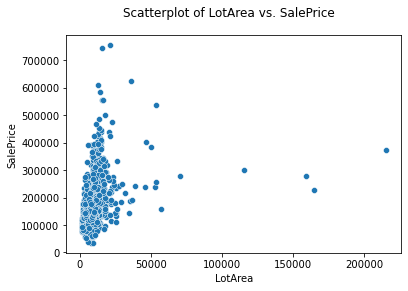

In [118]:
sns.scatterplot(x=X['LotArea'], y=y)

plt.suptitle('Scatterplot of LotArea vs. SalePrice')

It's cone-shaped again. But this time, I'm going to drop the four houses with the largest area.

In [119]:
indices_to_remove = X['LotArea'].nlargest(4).index

X = X.drop(indices_to_remove)

#### OpenPorchSF

Text(0.5, 0.98, 'Scatterplot of OpenPorchSF vs. SalePrice')

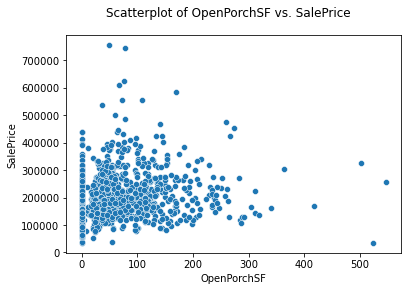

In [120]:
sns.scatterplot(x=X['OpenPorchSF'], y=y)

plt.suptitle('Scatterplot of OpenPorchSF vs. SalePrice')

I will drop 4 rows with the largest open porch square.

In [121]:
indices_to_remove = X['OpenPorchSF'].nlargest(4).index

X = X.drop(indices_to_remove)

### Double-check

Text(0.5, 1.0, 'OpenPorchSF / SalePrice')

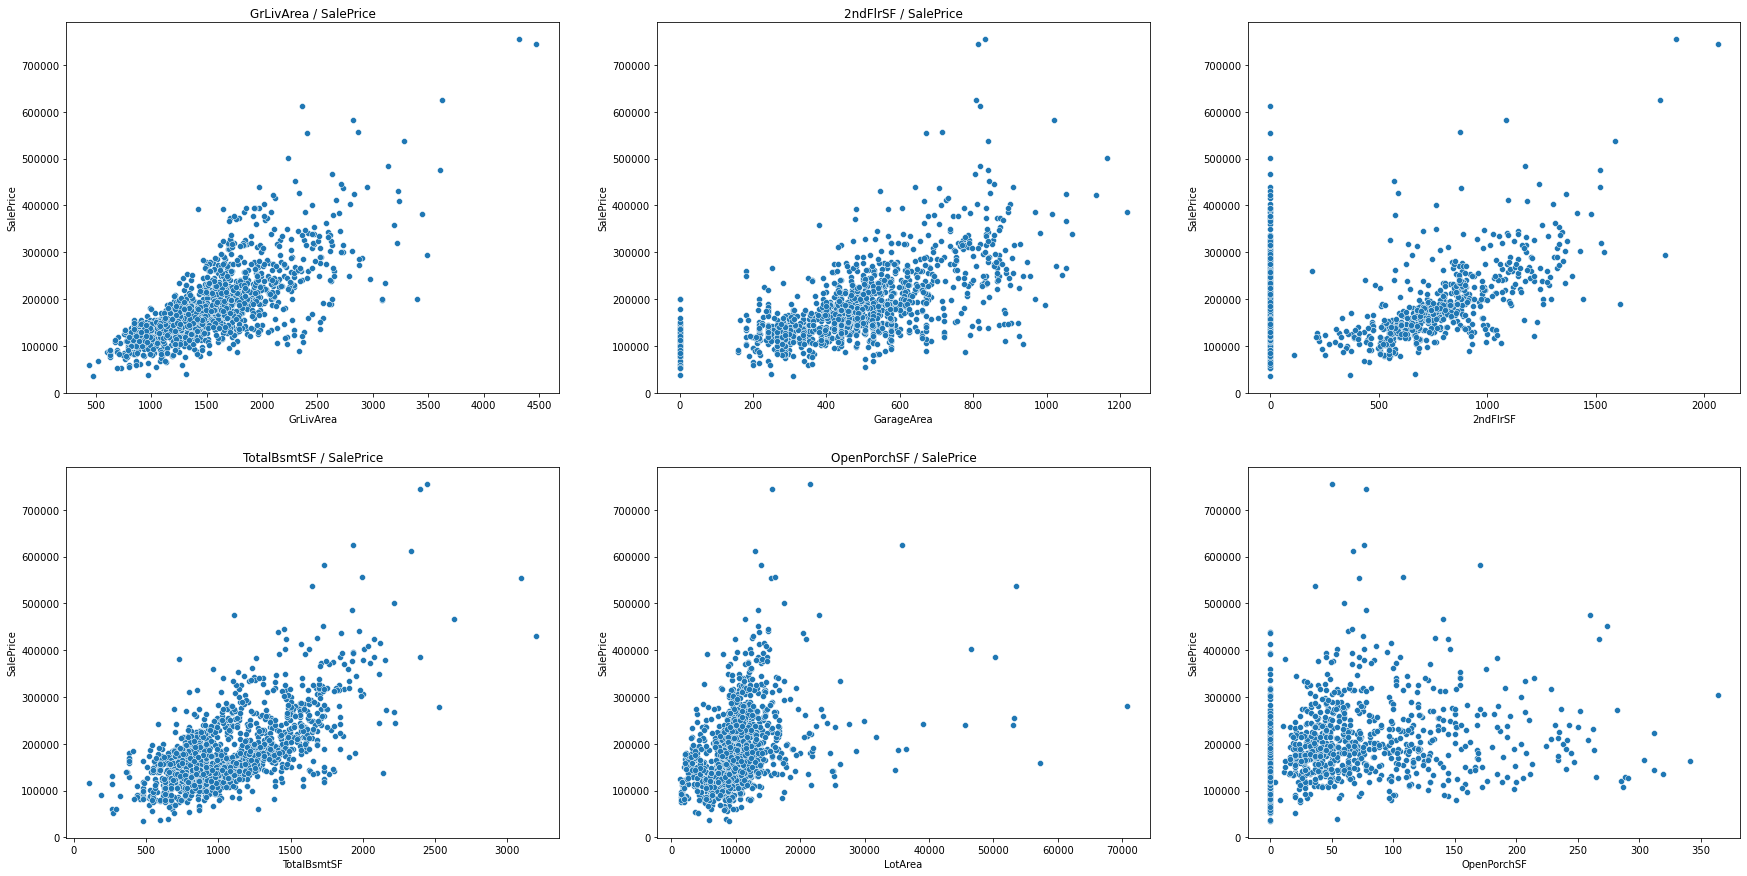

In [122]:
fig, axes = plt.subplots(2, 3, figsize=(30, 15))  

sns.scatterplot(x=X['GrLivArea'], y=y, ax=axes[0, 0])
axes[0, 0].set_title('GrLivArea / SalePrice')

sns.scatterplot(x=X['GarageArea'], y=y, ax=axes[0, 1])
axes[0, 1].set_title('GarageArea / SalePrice')

sns.scatterplot(x=X['2ndFlrSF'], y=y, ax=axes[0, 2])
axes[0, 1].set_title('2ndFlrSF / SalePrice')

sns.scatterplot(x=X['TotalBsmtSF'], y=y, ax=axes[1, 0])
axes[1, 0].set_title('TotalBsmtSF / SalePrice')

sns.scatterplot(x=X['LotArea'], y=y, ax=axes[1, 1])
axes[1, 1].set_title('LotArea / SalePrice')

sns.scatterplot(x=X['OpenPorchSF'], y=y, ax=axes[1, 2])
axes[1, 1].set_title('OpenPorchSF / SalePrice')

I would say there are still a few outliers in the LotArea and OpenPorchSF features. And I will still remove the 2 houses with the largest GrLivArea, although I wasn't going to do that before.

In [123]:
indices_to_remove = X['GrLivArea'].nlargest(2).index
indices_to_remove |= (X['LotArea'].nlargest(12).index)
indices_to_remove |= (X['OpenPorchSF'].nlargest(2).index)

X = X.drop(indices_to_remove)

y = y[X.index]

Attempt number two.

Text(0.5, 1.0, 'OpenPorchSF / SalePrice')

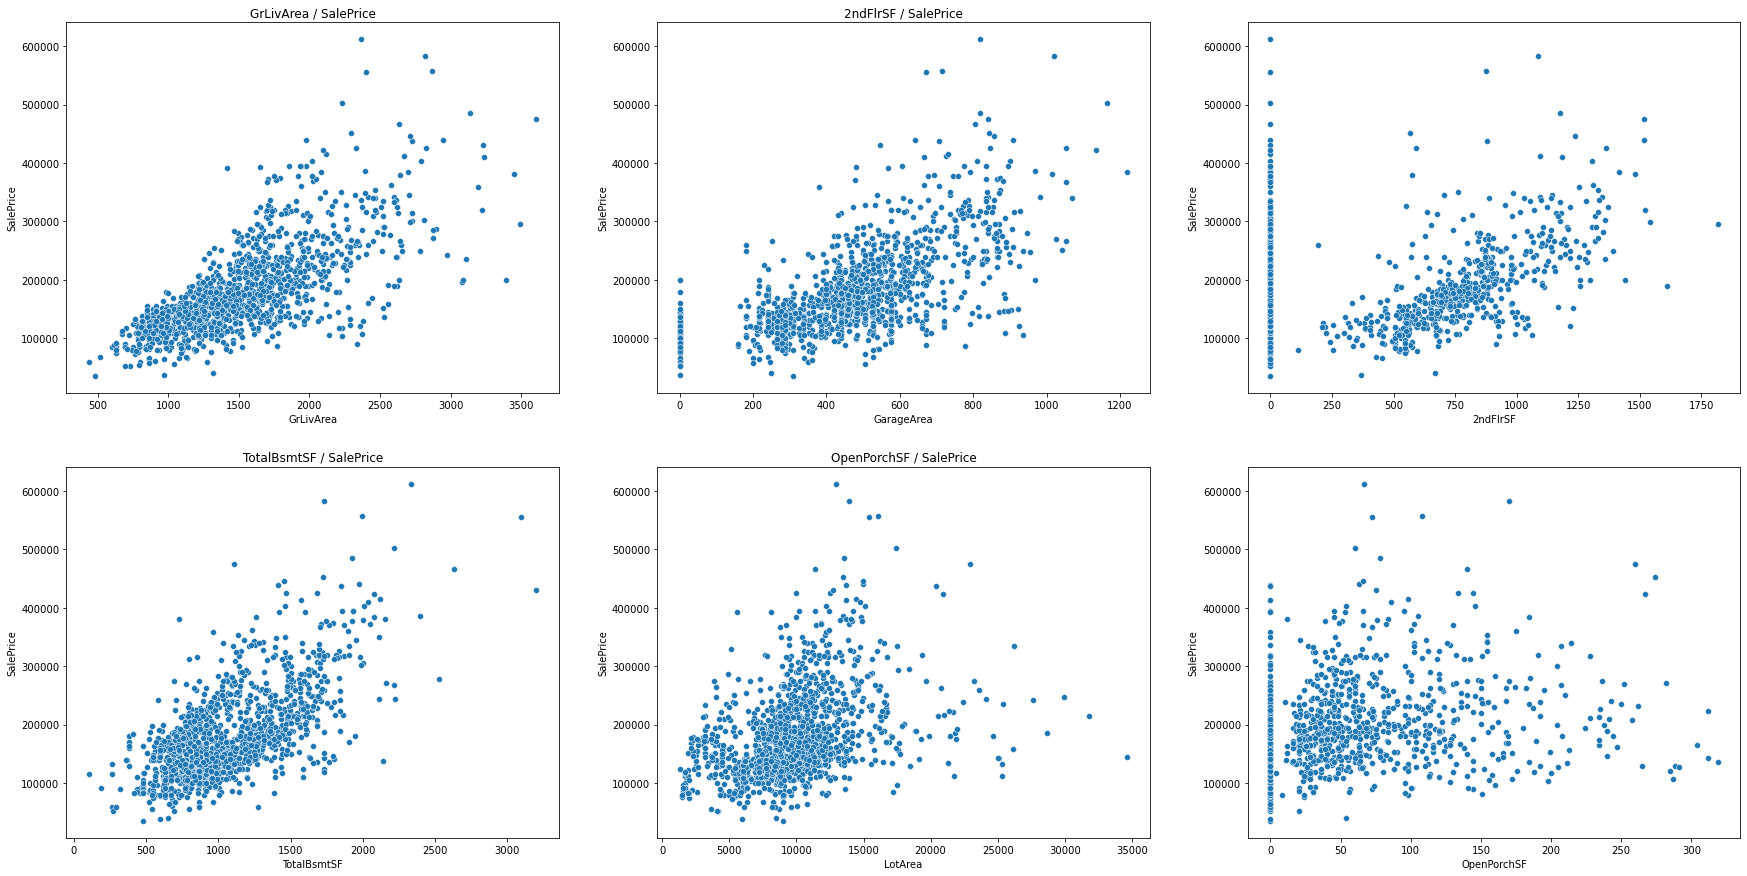

In [124]:
fig, axes = plt.subplots(2, 3, figsize=(30, 15))  

sns.scatterplot(x=X['GrLivArea'], y=y, ax=axes[0, 0])
axes[0, 0].set_title('GrLivArea / SalePrice')

sns.scatterplot(x=X['GarageArea'], y=y, ax=axes[0, 1])
axes[0, 1].set_title('GarageArea / SalePrice')

sns.scatterplot(x=X['2ndFlrSF'], y=y, ax=axes[0, 2])
axes[0, 1].set_title('2ndFlrSF / SalePrice')

sns.scatterplot(x=X['TotalBsmtSF'], y=y, ax=axes[1, 0])
axes[1, 0].set_title('TotalBsmtSF / SalePrice')

sns.scatterplot(x=X['LotArea'], y=y, ax=axes[1, 1])
axes[1, 1].set_title('LotArea / SalePrice')

sns.scatterplot(x=X['OpenPorchSF'], y=y, ax=axes[1, 2])
axes[1, 1].set_title('OpenPorchSF / SalePrice')

There are still examples in the LotArea and OpenPorchSF features that are away from the overall trend. But I wouldn't call them obvious outliers, so I won't remove them.   

Let's get to the categorical columns.

### Outliers in categorical columns

Let's first look at the situation as a whole.

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

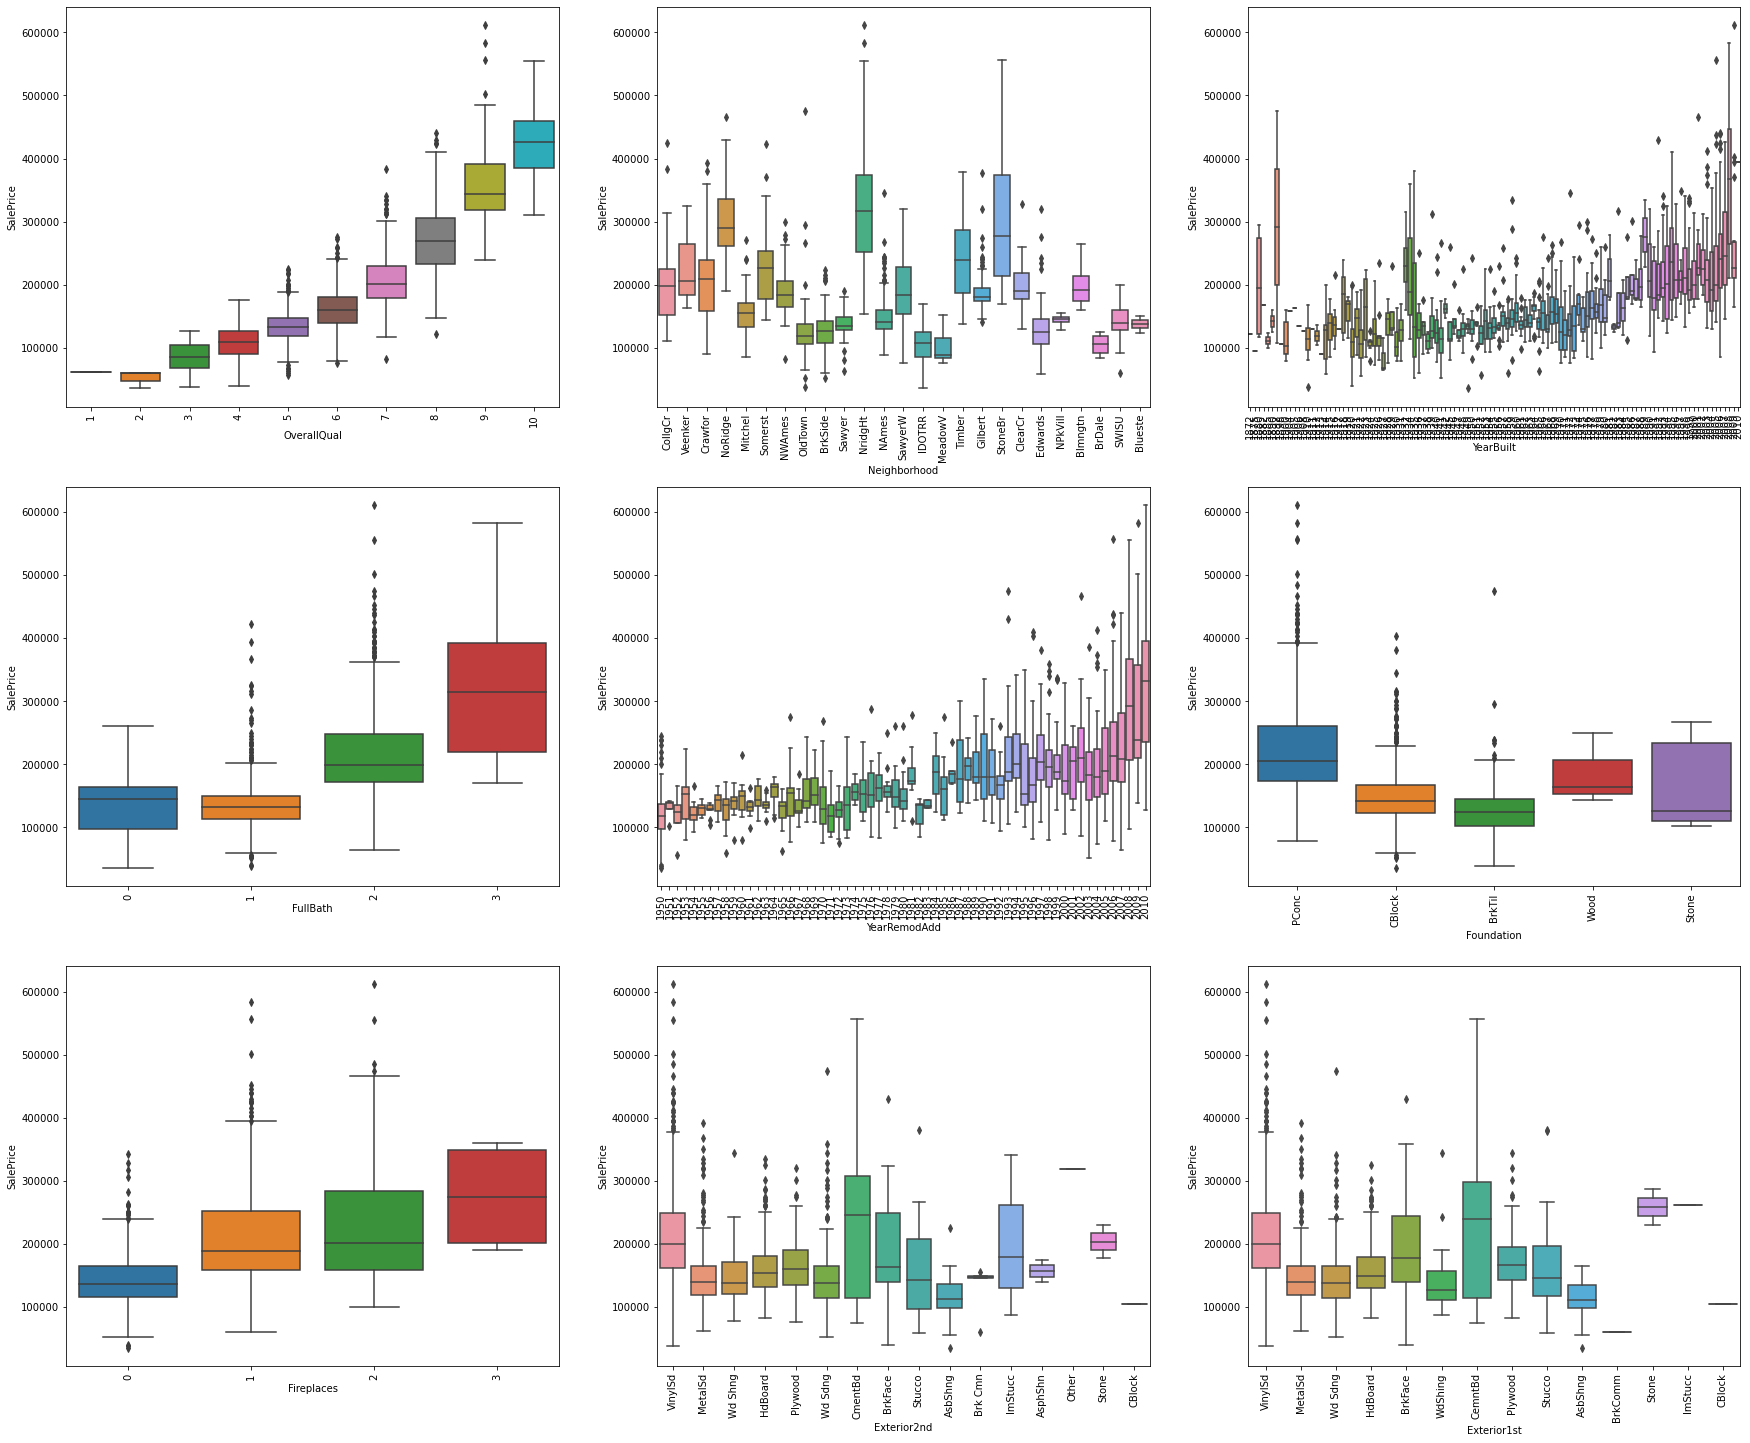

In [125]:
fig, axes = plt.subplots(3, 3, figsize=(30, 25))  

for ax in axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    
sns.boxplot(x=X['OverallQual'], y=y, ax=axes[0, 0])
sns.boxplot(x=X['Neighborhood'], y=y, ax=axes[0, 1])
sns.boxplot(x=X['YearBuilt'], y=y, ax=axes[0, 2])

sns.boxplot(x=X['FullBath'], y=y, ax=axes[1, 0])
sns.boxplot(x=X['YearRemodAdd'], y=y, ax=axes[1, 1])
sns.boxplot(x=X['Foundation'], y=y, ax=axes[1, 2])

sns.boxplot(x=X['Fireplaces'], y=y, ax=axes[2, 0])
sns.boxplot(x=X['Exterior2nd'], y=y, ax=axes[2, 1])
sns.boxplot(x=X['Exterior1st'], y=y, ax=axes[2, 2])

In [126]:
X.shape

(1383, 15)

Almost every category in every features seem to have outliers. It would take a long time to manually clean everything, and it would be very subjective.... So I need a function that would remove outliers by sticking to some system.  

To detect outliers in categorical columns, I will use the 1.5 IQR statistical rule, which is also used as an outlier detector in box plots. It states that an outlier is any value greater than `1.5 IQR` above the third quartile and any value `1.5 IQR` less than the first quartile.    

Let't create a fuction.

In [127]:
def drop_outliers_from_cat_cols(X, y, cat_cols):
    # Concat features with SalePrice 
    X_y = pd.concat([X, y], axis=1)
    
    # Create a list where outliers indices will be stored
    outliers_indices = []
    
    # Run through every categoty of every categorical feature
    for col in cat_cols:
        for category in X[col].unique():
            
            # Calculate the Interquartile Range for every category
            quartile1, quartile3 = np.percentile(X_y[X_y[col] == category]['SalePrice'], [25, 75])
            iqr = quartile3 - quartile1

            # Define the boundaries beyond which the value will be considered an outlier.
            low_border = quartile1 - 1.5 * iqr
            high_border = quartile3 + 1.5 * iqr
            
            # Get outliers indices of a particular category
            outliers_low_price = list(X_y[(X_y[col] == category) & (X_y['SalePrice'] <= low_border)].index)
            outliers_high_price = list(X_y[(X_y[col] == category) & (X_y['SalePrice'] >= high_border)].index)
            
            # Add indices to the outliers_indices
            outliers_indices += outliers_low_price + outliers_high_price
    
    if outliers_indices:
        # Only one appearance of every outlier index is necessary
        outliers_indices = set(outliers_indices)
        
        # Check if any outliers are already present in X or y
        outliers_indices = [idx for idx in outliers_indices if idx in X.index or idx in y.index]
        
        # Drop the outliers from X
        X = X.drop(index=outliers_indices)
                
        # Make sure than X and y indices match
        y = y[X.index]   
    
    
    return X, y

In [128]:
X.columns

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'GarageArea',
       'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '2ndFlrSF', 'Foundation',
       'Exterior2nd', 'LotArea', 'Fireplaces', 'OpenPorchSF', 'Exterior1st'],
      dtype='object')

In [129]:
cat_cols = ['OverallQual', 'Neighborhood', 'YearBuilt', 'FullBath', 'YearRemodAdd', 
            'Foundation','Exterior2nd', 'Fireplaces', 'Exterior1st']

In [130]:
X, y = drop_outliers_from_cat_cols(X, y, cat_cols)

### Double-check

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

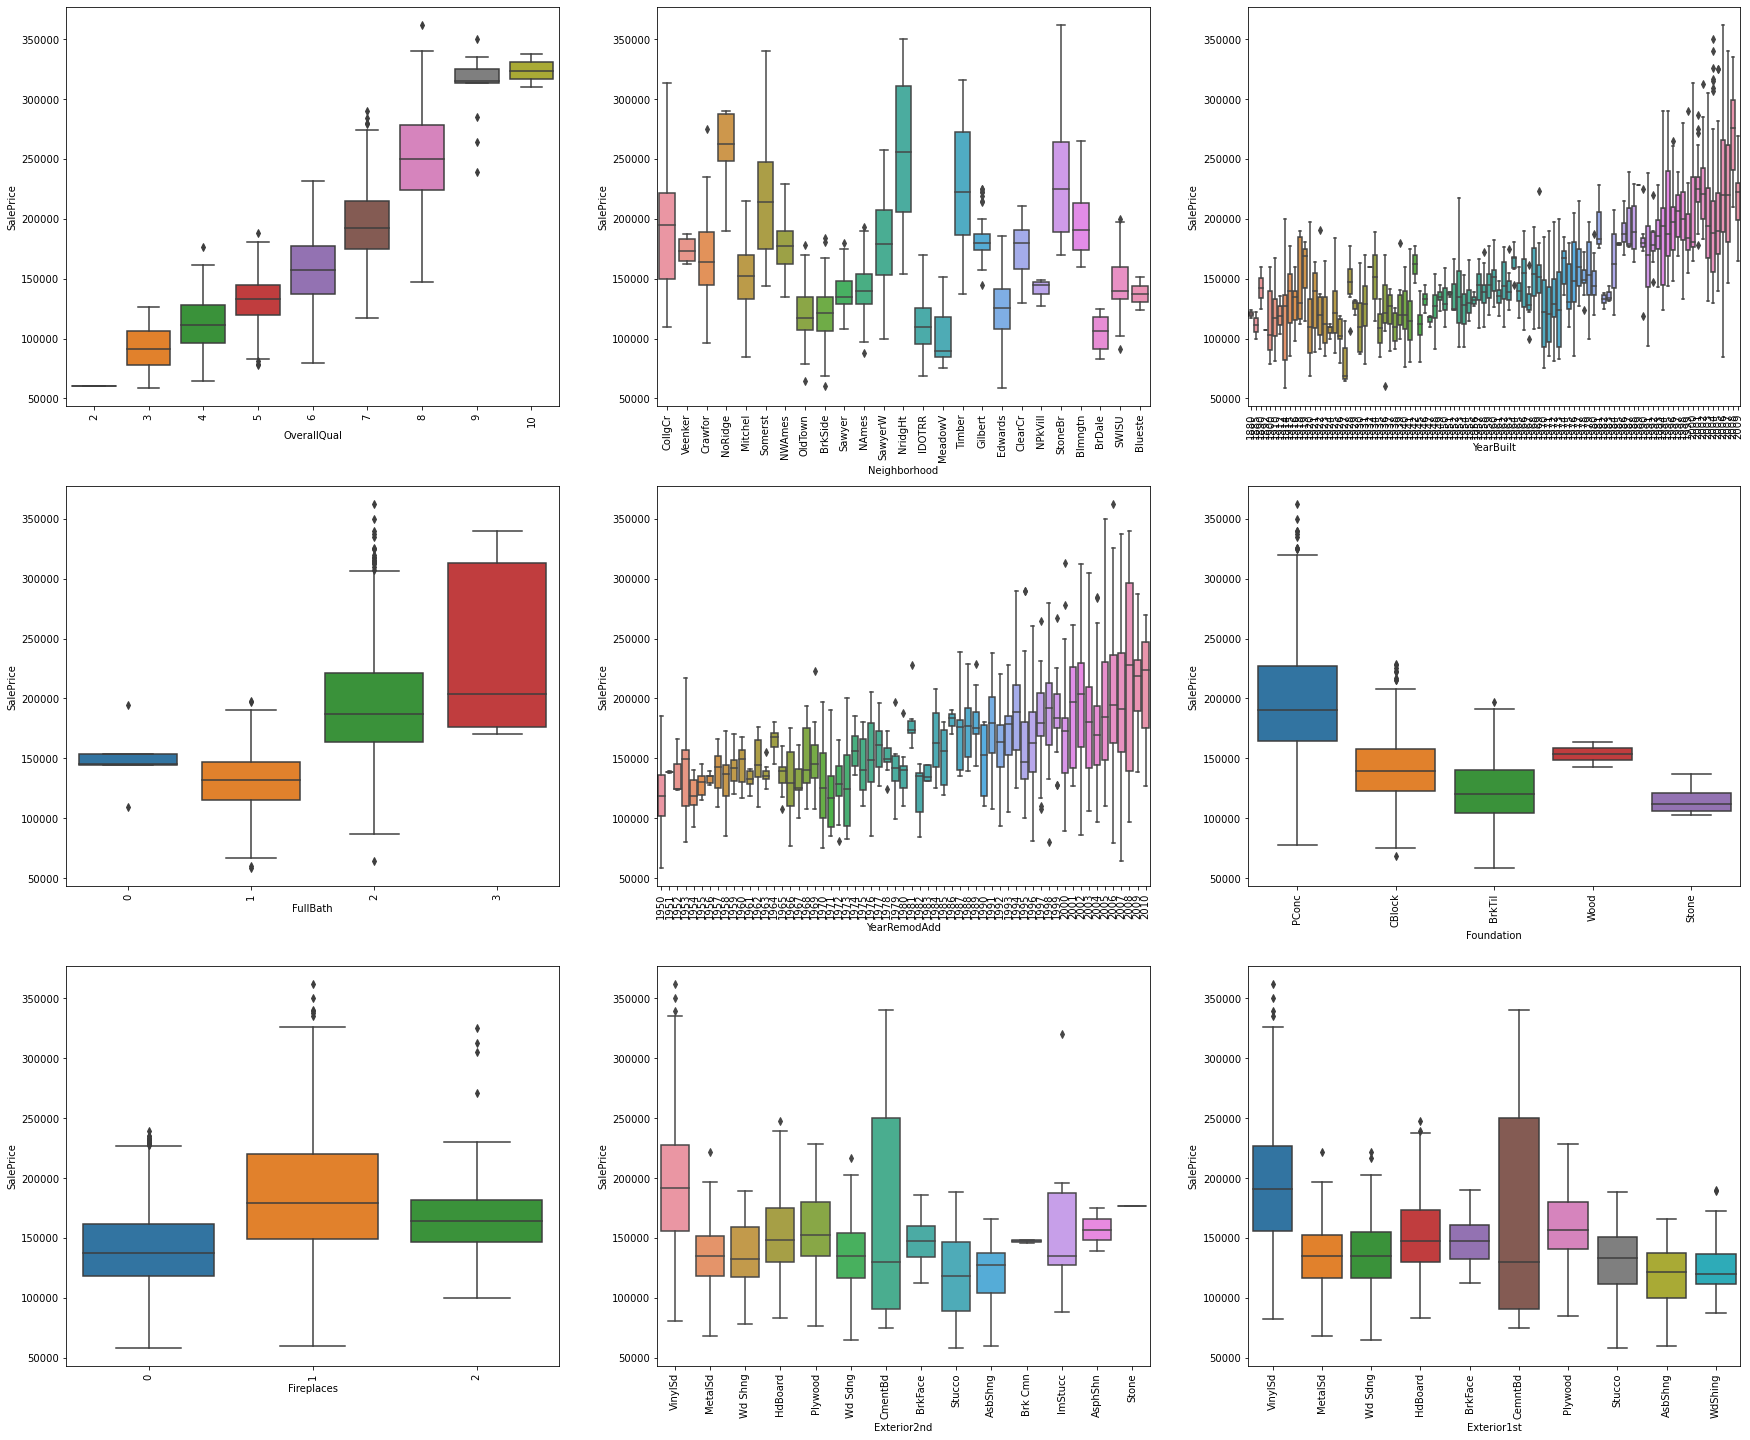

In [131]:
fig, axes = plt.subplots(3, 3, figsize=(30, 25))  

for ax in axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    
sns.boxplot(x=X['OverallQual'], y=y, ax=axes[0, 0])
sns.boxplot(x=X['Neighborhood'], y=y, ax=axes[0, 1])
sns.boxplot(x=X['YearBuilt'], y=y, ax=axes[0, 2])

sns.boxplot(x=X['FullBath'], y=y, ax=axes[1, 0])
sns.boxplot(x=X['YearRemodAdd'], y=y, ax=axes[1, 1])
sns.boxplot(x=X['Foundation'], y=y, ax=axes[1, 2])

sns.boxplot(x=X['Fireplaces'], y=y, ax=axes[2, 0])
sns.boxplot(x=X['Exterior2nd'], y=y, ax=axes[2, 1])
sns.boxplot(x=X['Exterior1st'], y=y, ax=axes[2, 2])

I'm satisfied with that)

In [132]:
X.shape

(1132, 15)

In [133]:
y = y[X.index]

In [134]:
X.columns

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'GarageArea',
       'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '2ndFlrSF', 'Foundation',
       'Exterior2nd', 'LotArea', 'Fireplaces', 'OpenPorchSF', 'Exterior1st'],
      dtype='object')

# Categorical Variables Encoding <a name = 'encoding'></a>  

[Table of Contents](#content)

Time to code categorical variables. Both training and validation data will be encoded.

In [135]:
# Match columns in two datasets
test_data = test_data[X.columns]

In [136]:
cat_cols_last = list(X.select_dtypes(include = 'object').columns)

X[cat_cols_last].head(3)

,Neighborhood,Foundation,Exterior2nd,Exterior1st
Id,,,,
1,CollgCr,PConc,VinylSd,VinylSd
2,Veenker,CBlock,MetalSd,MetalSd
3,CollgCr,PConc,VinylSd,VinylSd


It looks like we only need to encode a few categorical features. None of them have a hierarchy, so I think One-Hot coding would be just perfect.

In [137]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[cat_cols_last]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_data[cat_cols_last]))

# Get feature names after one-hot encoding
OH_feature_names = OH_encoder.get_feature_names_out(cat_cols_last)

# Set column names for one-hot encoded columns
OH_cols_train.columns = OH_feature_names
OH_cols_test.columns = OH_feature_names

# One-hot encoding removed index; put it back
OH_cols_train.index = X.index
OH_cols_test.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X.drop(cat_cols_last, axis=1)
num_X_test = test_data.drop(cat_cols_last, axis=1)

# Add one-hot encoded columns to numerical features
X_encoded = pd.concat([num_X_train, OH_cols_train], axis=1)
test_data_encoded = pd.concat([num_X_test, OH_cols_test], axis=1)

# Ensure all columns have string type
X_encoded.columns = X_encoded.columns.astype(str)
test_data_encoded.columns = test_data_encoded.columns.astype(str)

In [138]:
print(X_encoded.shape)
X_encoded.head(1)

(1132, 65)


,OverallQual,GrLivArea,YearBuilt,GarageArea,TotalBsmtSF,FullBath,YearRemodAdd,2ndFlrSF,LotArea,Fireplaces,OpenPorchSF,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior1st_AsbShng,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7,1710,2003,548,856,2,2003,854,8450,0,61,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Saving the Processed Data <a name = 'csv'></a> 

[Table of Contents](#content) 

Write `X` as a new `.csv` file for model training.

In [139]:
# Save train data
data_processed = pd.concat([X_encoded, y.rename('SalePrice')], axis = 1)
data_processed.to_csv('../../Data/train_data_processed.csv')

# Save test data
test_data_encoded.to_csv('../../Data/test_data_processed.csv')

# Fitting Data to Statistical Norms <a name = 'stats'></a>  

[Table of Contents](#content)

Some machine learning models can benefit from data normality. I'm not sure if fitting statistical norms will improve the performance of my models, but I'll still create another csv file to experiment with this.    

There is an excellent `log` function that in some cases solves not only the normality problem but also the heteroscedasticity problem. I will try to apply the log function to my data.    

First, let's explore our number features using these tools:
* **Scatterplot**
* **Histogram** - Kurtosis and skewness.
* **Normal probability plot** - Data distribution should closely follow the diagonal that represents the normal distribution.

((array([-3.23316535, -2.97065473, -2.82433581, ...,  2.82433581,
          2.97065473,  3.23316535]),
  array([  0,   0,   0, ..., 304, 312, 319], dtype=int64)),
 (49.14395044190681, 40.77385159010601, 0.8656868317755441))

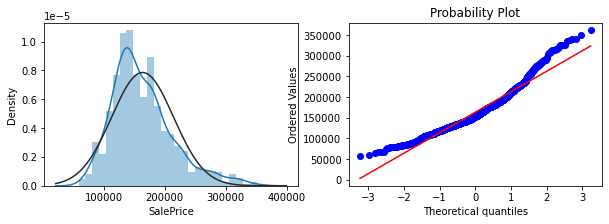

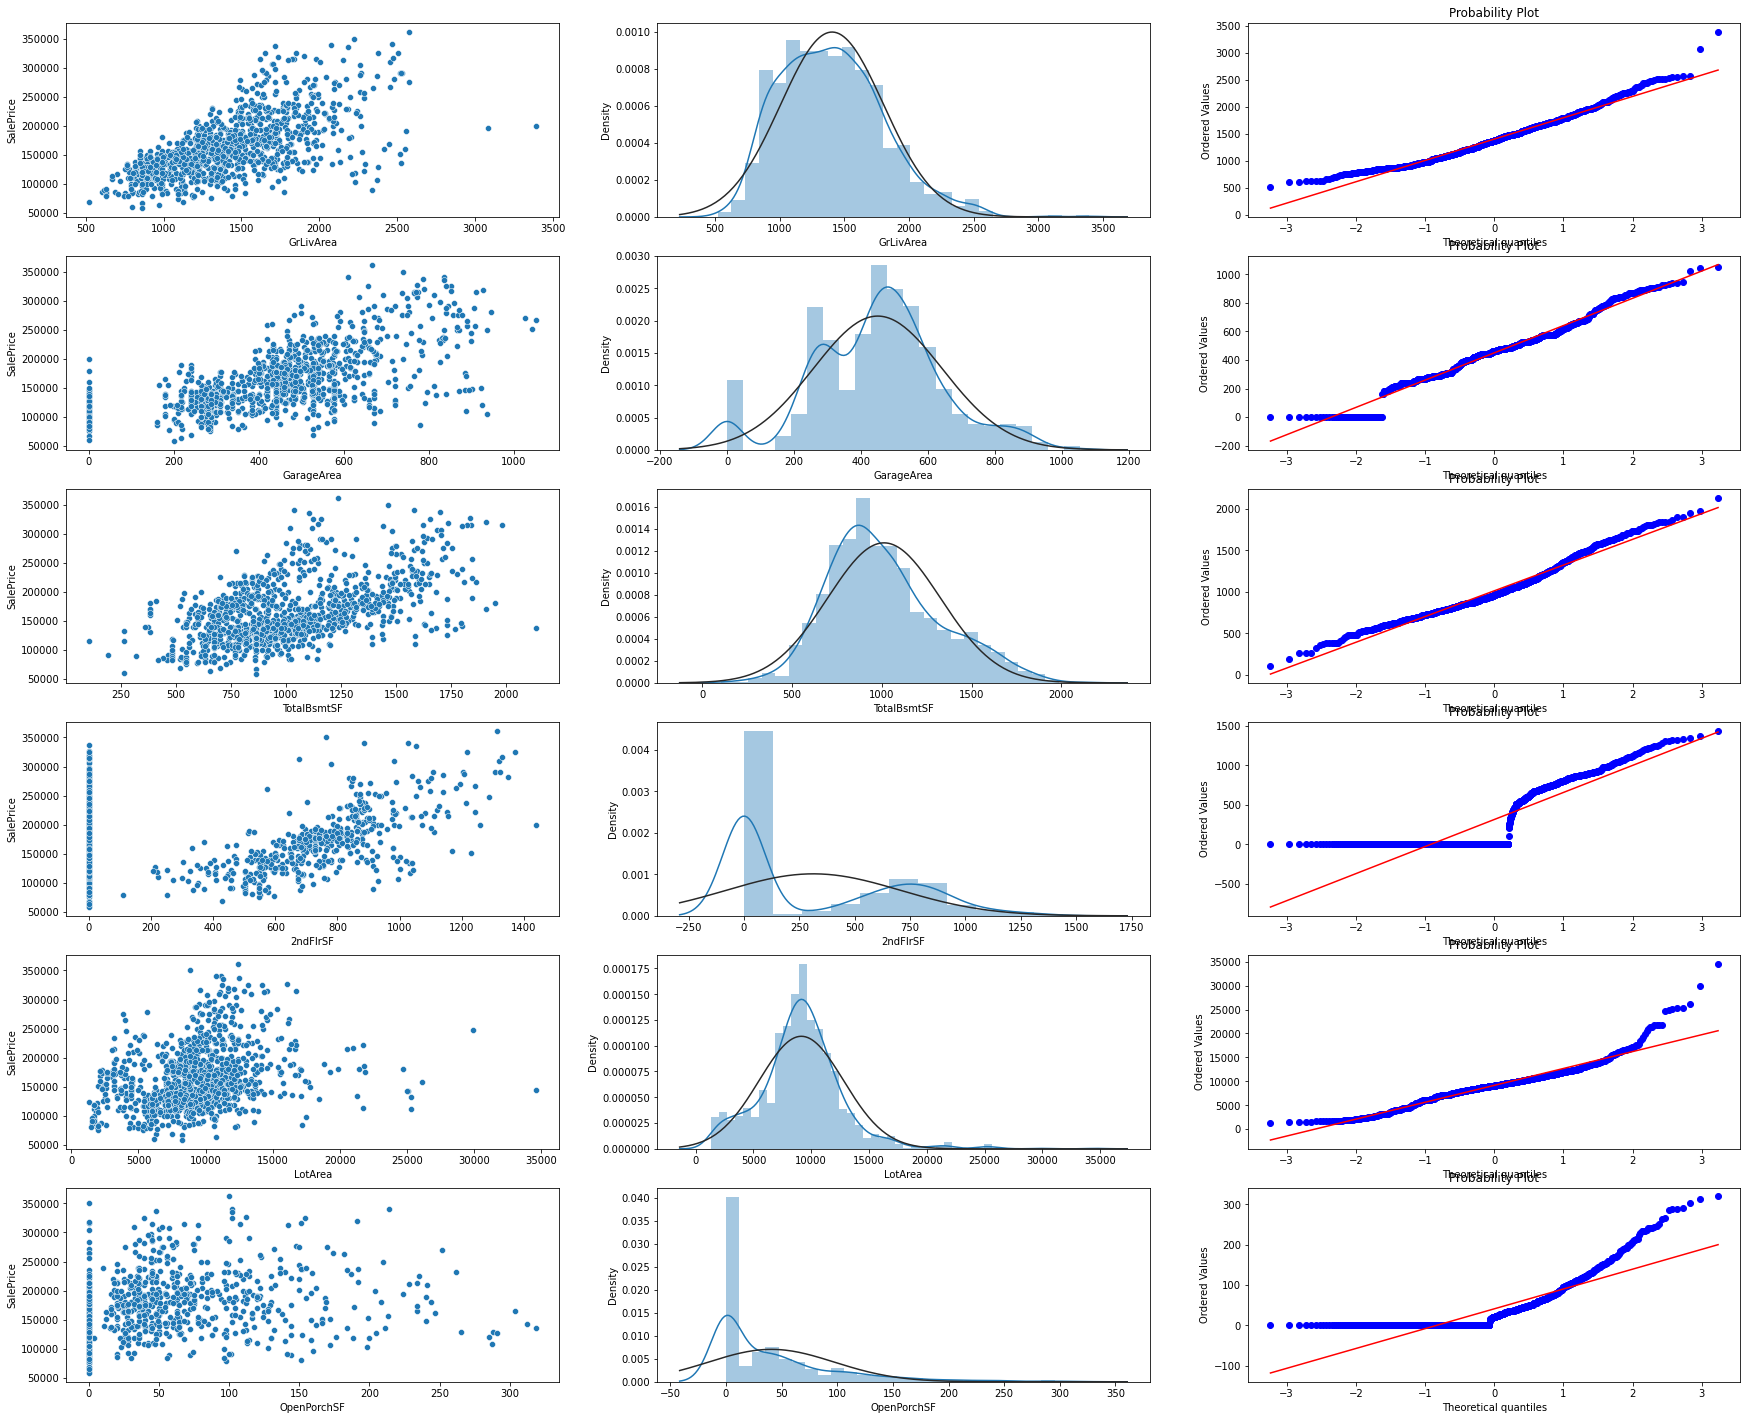

In [140]:
import warnings
warnings.filterwarnings("ignore")

data_full = pd.concat([X, y], axis = 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 3)) 

#SalePrice
sns.distplot(data_full['SalePrice'], fit=norm, ax=axes[0]);
stats.probplot(data_full['SalePrice'], plot=axes[1])

fig, axes = plt.subplots(6, 3, figsize=(30, 25))  

#GrLivArea
sns.scatterplot(x=data_full['GrLivArea'], y=data_full['SalePrice'], ax=axes[0, 0])
sns.distplot(data_full['GrLivArea'], fit=norm, ax=axes[0, 1])
stats.probplot(data_full['GrLivArea'], plot=axes[0, 2])

#GarageArea
sns.scatterplot(x=data_full['GarageArea'], y=data_full['SalePrice'], ax=axes[1, 0])
sns.distplot(data_full['GarageArea'], fit=norm, ax=axes[1, 1])
stats.probplot(data_full['GarageArea'], plot=axes[1, 2])

#TotalBsmtSF
sns.scatterplot(x=data_full['TotalBsmtSF'], y=data_full['SalePrice'], ax=axes[2, 0])
sns.distplot(data_full['TotalBsmtSF'], fit=norm, ax=axes[2, 1])
stats.probplot(data_full['TotalBsmtSF'], plot=axes[2, 2])

#2ndFlrSF
sns.scatterplot(x=data_full['2ndFlrSF'], y=data_full['SalePrice'], ax=axes[3, 0])
sns.distplot(data_full['2ndFlrSF'], fit=norm, ax=axes[3, 1])
stats.probplot(data_full['2ndFlrSF'], plot=axes[3, 2])

#LotArea
sns.scatterplot(x=data_full['LotArea'], y=data_full['SalePrice'], ax=axes[4, 0])
sns.distplot(data_full['LotArea'], fit=norm, ax=axes[4, 1])
stats.probplot(data_full['LotArea'], plot=axes[4, 2])

#OpenPorchSF
sns.scatterplot(x=data_full['OpenPorchSF'], y=data_full['SalePrice'], ax=axes[5, 0])
sns.distplot(data_full['OpenPorchSF'], fit=norm, ax=axes[5, 1])
stats.probplot(data_full['OpenPorchSF'], plot=axes[5, 2])

All features including the target variable show deviation from normal distribution to some degree. Let's apply the log function and look at the result.     

The log function can't work with zero-values, so we will transform only rows with non-zero values.

In [141]:
for col in ['SalePrice', 'GrLivArea', 'LotArea']:
    data_full[col] = np.log(data_full[col])

for col in ['GarageArea', '2ndFlrSF', 'OpenPorchSF', 'TotalBsmtSF']:
    data_full.loc[data_full[col] > 0, col] = np.log(data_full[col])

Checking the result.

((array([-3.23316535, -2.97065473, -2.82433581, ...,  2.82433581,
          2.97065473,  3.23316535]),
  array([0.        , 0.        , 0.        , ..., 5.7170277 , 5.74300319,
         5.7651911 ])),
 (1.8595037375416648, 2.167504549852054, 0.8788079502633485))

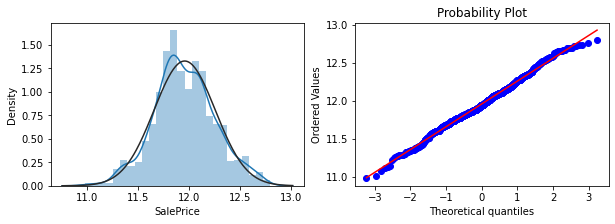

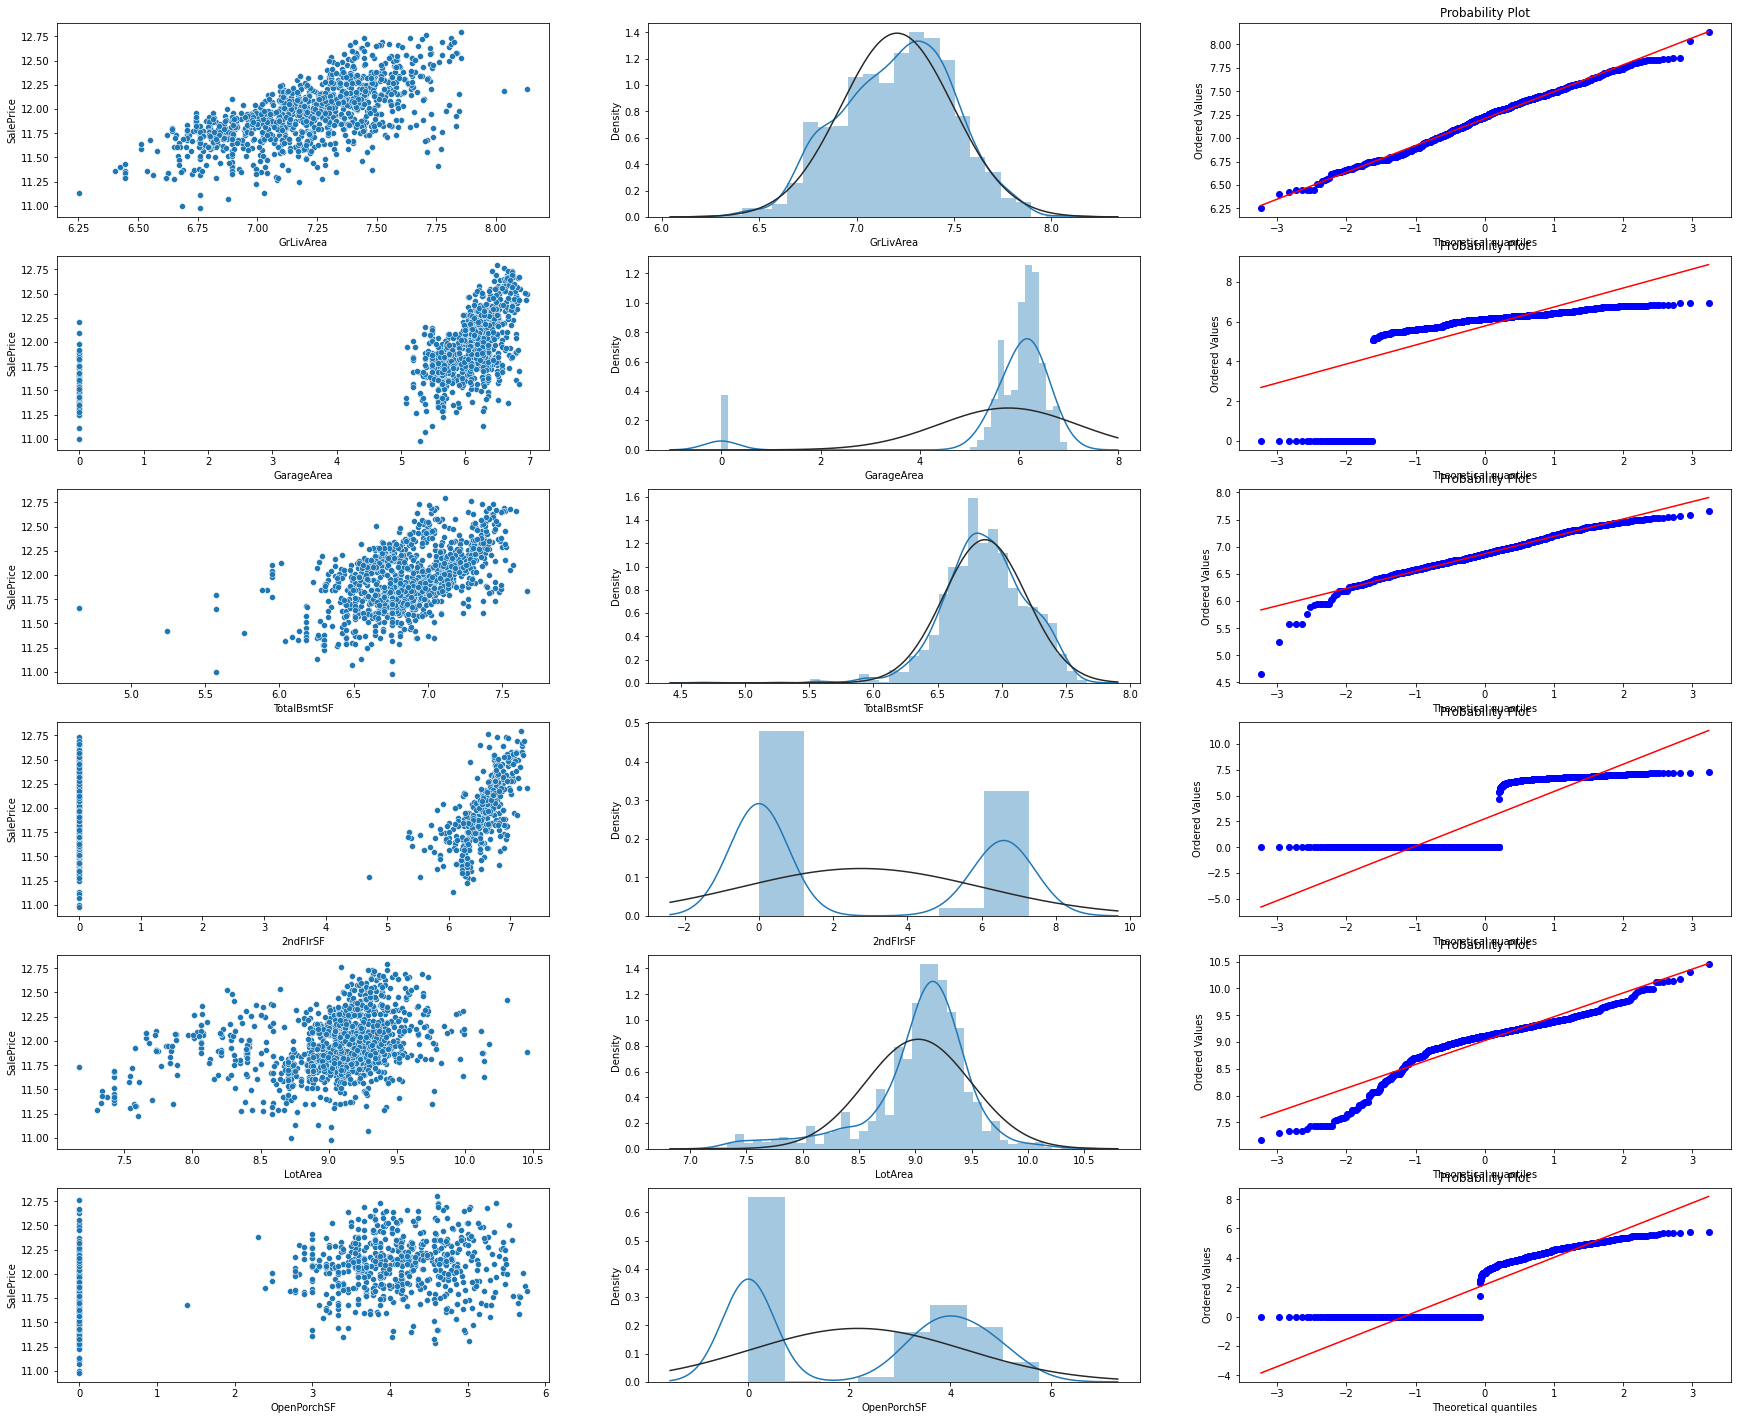

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

#SalePrice
sns.distplot(data_full['SalePrice'], fit=norm, ax = axes[0]);
stats.probplot(data_full['SalePrice'], plot=axes[1])

fig, axes = plt.subplots(6, 3, figsize=(30, 25))  

#GrLivArea
sns.scatterplot(x=data_full['GrLivArea'], y=data_full['SalePrice'], ax=axes[0, 0])
sns.distplot(data_full['GrLivArea'], fit=norm, ax=axes[0, 1])
stats.probplot(data_full['GrLivArea'], plot=axes[0, 2])

#GarageArea
sns.scatterplot(x=data_full['GarageArea'], y=data_full['SalePrice'], ax=axes[1, 0])
sns.distplot(data_full['GarageArea'], fit=norm, ax=axes[1, 1])
stats.probplot(data_full['GarageArea'], plot=axes[1, 2])

#TotalBsmtSF
sns.scatterplot(x=data_full['TotalBsmtSF'], y=data_full['SalePrice'], ax=axes[2, 0])
sns.distplot(data_full['TotalBsmtSF'], fit=norm, ax=axes[2, 1])
stats.probplot(data_full['TotalBsmtSF'], plot=axes[2, 2])

#2ndFlrSF
sns.scatterplot(x=data_full['2ndFlrSF'], y=data_full['SalePrice'], ax=axes[3, 0])
sns.distplot(data_full['2ndFlrSF'], fit=norm, ax=axes[3, 1])
stats.probplot(data_full['2ndFlrSF'], plot=axes[3, 2])

#LotArea
sns.scatterplot(x=data_full['LotArea'], y=data_full['SalePrice'], ax=axes[4, 0])
sns.distplot(data_full['LotArea'], fit=norm, ax=axes[4, 1])
stats.probplot(data_full['LotArea'], plot=axes[4, 2])

#OpenPorchSF
sns.scatterplot(x=data_full['OpenPorchSF'], y=data_full['SalePrice'], ax=axes[5, 0])
sns.distplot(data_full['OpenPorchSF'], fit=norm, ax=axes[5, 1])
stats.probplot(data_full['OpenPorchSF'], plot=axes[5, 2])

It seems that the log function improved the situation only for `SalePrice`, `GrLivArea` and `TotalBsmtSF`. For other features it made things worse. So I will only change three columns in my new csv file.

In [143]:
train_data_stats = data_processed.copy()

train_data_stats['SalePrice'] = np.log(train_data_stats['SalePrice'])
train_data_stats['GrLivArea'] = np.log(train_data_stats['GrLivArea'])
train_data_stats.loc[train_data_stats['TotalBsmtSF'] > 0, 'TotalBsmtSF'] = np.log(train_data_stats['TotalBsmtSF'])

Do the same for test data.

In [144]:
test_data_stats = test_data_encoded.copy()

test_data_stats['GrLivArea'] = np.log(test_data_stats['GrLivArea'])
test_data_stats.loc[test_data_stats['TotalBsmtSF'] > 0, 'TotalBsmtSF'] = np.log(test_data_stats['TotalBsmtSF'])

# Saving Data with Normalized Columns <a name = 'save_norm'></a>  

[Table of Contents](#content)

In [145]:
data_processed_stats.to_csv('../../Data/train_data_stats.csv')

test_data_stats.to_csv('../../Data/test_data_stats.csv')

I think that's enough for EDA. Let's move on to modeling!